# Simplified Linear VMM (Vessel Maneuvering Model)

# Purpose
Implementing according to:
Matusiak, Jerzy. Dynamics of a Rigid Ship. Aalto University, 2017. https://aaltodoc.aalto.fi:443/handle/123456789/24408.

# Methodology
Define the problem using SymPy

# Setup

In [2]:
# %load imports.py
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import matplotlib.pyplot as plt

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns
import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex
from src.substitute_dynamic_symbols import run, lambdify

import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp

## Local packages:
#from src.data import mdl
from src import symbols
from src import prime_system
from src.symbols import *
from src.linear_vmm_equations import *

import src.linear_vmm_simplified_equations as eq
import src.models.linear_vmm as model
from src.visualization.plot import track_plot
import src.nonlinear_vmm_equations as nonlinear_vmm_equations


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
symbols.df_parameters

,coord,dof,state,symbol,brix,brix_lambda
Xu,u,X,,X_{u},NaN,NaN
Xudot,u,X,dot,X_{\dot{u}},NaN,NaN
Xv,v,X,,X_{v},NaN,NaN
Xvdot,v,X,dot,X_{\dot{v}},NaN,NaN
Xr,r,X,,X_{r},NaN,NaN
Xrdot,r,X,dot,X_{\dot{r}},NaN,NaN
Xdelta,\delta,X,,X_{\delta},NaN,NaN
Xdeltadot,\delta,X,dot,X_{\dot{\delta}},NaN,NaN
Yu,u,Y,,Y_{u},NaN,NaN
Yudot,u,Y,dot,Y_{\dot{u}},NaN,NaN


## Linearized simplified equation of motion ($x_G=0$)

### X

Nonlinear equation of motion in X-direction:

In [4]:
Math(vlatex(nonlinear_vmm_equations.X_eom))

<IPython.core.display.Math object>

this equation is linearized by assuming : $v=0$ and dropping $r^2$

In [5]:
Math(vlatex(eq.X_eom))

<IPython.core.display.Math object>

### Y

Nonlinear equation of motion in Y-direction:

In [6]:
Math(vlatex(nonlinear_vmm_equations.Y_eom))

<IPython.core.display.Math object>

this equation is linearized by assuming that $u \approx U $ where $U$ is the initial total velocity.

In [7]:
Math(vlatex(eq.Y_eom))

<IPython.core.display.Math object>

### N

Nonlinear equation of motion in N-direction:

In [8]:
Math(vlatex(nonlinear_vmm_equations.N_eom))

<IPython.core.display.Math object>

this equation is linearized by assuming that $u \approx U $ where $U$ is the initial total velocity.

In [9]:
Math(vlatex(eq.N_eom))

<IPython.core.display.Math object>

In [10]:
Math(vlatex(eq.fx_eq))

<IPython.core.display.Math object>

In [11]:
Math(vlatex(eq.fy_eq))

<IPython.core.display.Math object>

In [12]:
Math(vlatex(eq.mz_eq))

<IPython.core.display.Math object>

In [13]:
Math(vlatex(eq.X_eq))

<IPython.core.display.Math object>

In [14]:
Math(vlatex(eq.Y_eq))

<IPython.core.display.Math object>

In [15]:
Math(vlatex(eq.N_eq))

<IPython.core.display.Math object>

In [16]:
r1d_eq = sp.Eq(r.diff(), sp.solve(N_eq, r.diff())[0])

## Steady state solution

In [17]:
X_steady = X_eq.subs([
    (u.diff(),0),
    (v.diff(),0),
    (r.diff(),0),
          ])
X_steady

Eq(0, X_{\delta}*delta(t) + X_{r}*r(t) + X_{u}*u(t) + X_{v}*v(t))

In [18]:
Y_steady = Y_eq.subs([
    (u.diff(),0),
    (v.diff(),0),
    (r.diff(),0),
          ])
Y_steady

Eq(U*m*r(t), Y_{\delta}*delta(t) + Y_{r}*r(t) + Y_{u}*u(t) + Y_{v}*v(t))

In [19]:
N_steady = N_eq.subs([
    (u.diff(),0),
    (v.diff(),0),
    (r.diff(),0),
          ])
N_steady

Eq(U*m*x_G*r(t), N_{\delta}*delta(t) + N_{r}*r(t) + N_{u}*u(t) + N_{v}*v(t))

In [20]:
eqs = [Y_steady,N_steady]
solution = sp.solve(eqs,v,r, dict=True)
solution[0][v]

-N_{\delta}*U*m*delta(t)/(N_{r}*Y_{v} + N_{v}*U*m - N_{v}*Y_{r} - U*Y_{v}*m*x_G) + N_{\delta}*Y_{r}*delta(t)/(N_{r}*Y_{v} + N_{v}*U*m - N_{v}*Y_{r} - U*Y_{v}*m*x_G) - N_{r}*Y_{\delta}*delta(t)/(N_{r}*Y_{v} + N_{v}*U*m - N_{v}*Y_{r} - U*Y_{v}*m*x_G) - N_{r}*Y_{u}*u(t)/(N_{r}*Y_{v} + N_{v}*U*m - N_{v}*Y_{r} - U*Y_{v}*m*x_G) - N_{u}*U*m*u(t)/(N_{r}*Y_{v} + N_{v}*U*m - N_{v}*Y_{r} - U*Y_{v}*m*x_G) + N_{u}*Y_{r}*u(t)/(N_{r}*Y_{v} + N_{v}*U*m - N_{v}*Y_{r} - U*Y_{v}*m*x_G) + U*Y_{\delta}*m*x_G*delta(t)/(N_{r}*Y_{v} + N_{v}*U*m - N_{v}*Y_{r} - U*Y_{v}*m*x_G) + U*Y_{u}*m*x_G*u(t)/(N_{r}*Y_{v} + N_{v}*U*m - N_{v}*Y_{r} - U*Y_{v}*m*x_G)

In [21]:
solution[0][r]

-N_{\delta}*Y_{v}*delta(t)/(N_{r}*Y_{v} + N_{v}*U*m - N_{v}*Y_{r} - U*Y_{v}*m*x_G) - N_{u}*Y_{v}*u(t)/(N_{r}*Y_{v} + N_{v}*U*m - N_{v}*Y_{r} - U*Y_{v}*m*x_G) + N_{v}*Y_{\delta}*delta(t)/(N_{r}*Y_{v} + N_{v}*U*m - N_{v}*Y_{r} - U*Y_{v}*m*x_G) + N_{v}*Y_{u}*u(t)/(N_{r}*Y_{v} + N_{v}*U*m - N_{v}*Y_{r} - U*Y_{v}*m*x_G)

In [22]:
subs = {value:key for key,value in eq.p.items()}
#u_lambda = lambdify(solution[0][u].subs(subs))
v_lambda = lambdify(solution[0][v].subs(subs))
r_lambda = lambdify(solution[0][r].subs(subs))

## Prime system

In [23]:
prime_system.df_prime.loc[['denominator']]

,length,mass,density,inertia_moment,time,area,angle,-,linear_velocity,angular_velocity,linear_acceleration,angular_acceleration,force,moment
denominator,L,0.5*L**3*rho,0.5*rho,0.5*L**5*rho,L/U,L**2,1,1,U,U/L,U**2/L,U**2/L**2,0.5*L**2*U**2*rho,0.5*L**3*U**2*rho


## Ship parameters

In [24]:
T_ =10
L_ = 200
CB_ = 0.7
B_ = 30
rho_ = 1025
m_ = T_*B_*L_*CB_*rho_

ship_parameters = {
        'T' : T_,
        'L' : L_,
        'CB' :CB_,
        'B' : B_,
        'rho' : rho_,
        'x_G' : 0,
        'm' : m_,
        'I_z': 0.2*m_*L_**2, 
    }

ps = prime_system.PrimeSystem(**ship_parameters)


In [25]:
def calculate_prime(row, ship_parameters):
    return run(function=row['brix_lambda'], inputs=ship_parameters)

mask = df_parameters['brix_lambda'].notnull()
df_parameters.loc[mask,'prime'] = df_parameters.loc[mask].apply(calculate_prime, ship_parameters=ship_parameters, axis=1)
df_parameters.loc['Ydelta','prime'] = 0.0005  # Just guessing
df_parameters.loc['Ndelta','prime'] = -df_parameters.loc['Ydelta','prime']/4  # Just guessing

In [26]:
df_parameters['prime'].fillna(0, inplace=True)
df_parameters

,coord,dof,state,symbol,brix,brix_lambda,prime
Xu,u,X,,X_{u},NaN,NaN,0.000000
Xudot,u,X,dot,X_{\dot{u}},NaN,NaN,0.000000
Xv,v,X,,X_{v},NaN,NaN,0.000000
Xvdot,v,X,dot,X_{\dot{v}},NaN,NaN,0.000000
Xr,r,X,,X_{r},NaN,NaN,0.000000
Xrdot,r,X,dot,X_{\dot{r}},NaN,NaN,0.000000
Xdelta,\delta,X,,X_{\delta},NaN,NaN,0.000000
Xdeltadot,\delta,X,dot,X_{\dot{\delta}},NaN,NaN,0.000000
Yu,u,Y,,Y_{u},NaN,NaN,0.000000
Yudot,u,Y,dot,Y_{\dot{u}},NaN,NaN,0.000000


## Steady turning

In [27]:
inputs = dict(df_parameters['prime'])
inputs.update(ps.prime(ship_parameters))

U = 10
delta = np.deg2rad(35)
inputs['delta'] = delta
inputs['u'] = inputs['U'] =  ps._prime(U,'linear_velocity', U=U)


v_steady_prime = run(function=v_lambda, inputs=inputs)
r_steady_prime = run(function=r_lambda, inputs=inputs)

v_steady = ps._unprime(v_steady_prime,'linear_velocity', U=U)
r_steady = ps._unprime(r_steady_prime,'angular_velocity' ,U=U)


In [28]:
v_steady

-3.7096905140118333

In [29]:
r_steady

0.03891847873613277

In [30]:
model.u1d_lambda

<function _lambdifygenerated(I_z, Ndelta, Nr, Nrdot, Nu, Nudot, Nv, Nvdot, U, Xdelta, Xr, Xrdot, Xu, Xudot, Xv, Xvdot, Ydelta, Yr, Yrdot, Yu, Yudot, Yv, Yvdot, delta, m, r, u, v, x_G)>

In [31]:
model.v1d_lambda

<function _lambdifygenerated(I_z, Ndelta, Nr, Nrdot, Nu, Nudot, Nv, Nvdot, U, Xdelta, Xr, Xrdot, Xu, Xudot, Xv, Xvdot, Ydelta, Yr, Yrdot, Yu, Yudot, Yv, Yvdot, delta, m, r, u, v, x_G)>

In [32]:
states = {
    'u' : ps._prime(U,'linear_velocity',U=U),
    'v' : ps._prime(v_steady,'linear_velocity',U=U),
    'r' : ps._prime(r_steady,'angular_velocity',U=U),
    #'u1d' : 0,
    #'v1d' : 0,
    #'r1d' : 0,
    
}

control = {
    'delta' : delta,
    'U' : ps._prime(U,'linear_velocity',U=U)
}

inputs = dict(df_parameters['prime'])
inputs.update(ps.prime(ship_parameters))

inputs.update(states)
inputs.update(control)

run(function=model.v1d_lambda, inputs=inputs)

1.734723475976807e-17

In [33]:
run(function=model.u1d_lambda, inputs=inputs)

0.0

In [34]:
run(function=model.v1d_lambda, inputs=inputs)

1.734723475976807e-17

In [35]:
run(function=model.r1d_lambda, inputs=inputs)

-1.5959455978986625e-16

<AxesSubplot:>

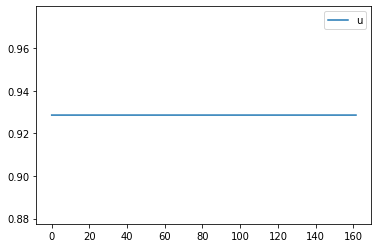

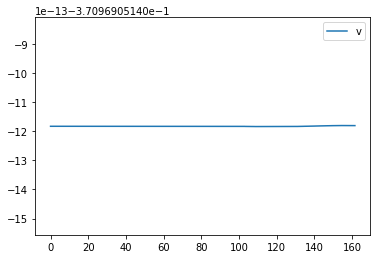

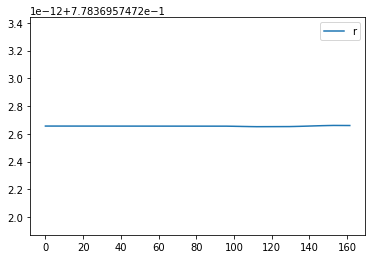

In [36]:
t_max = 2*np.pi/r_steady  # Turn one lap
t = np.arange(0,t_max,0.01)


control = {
    'delta' : delta,
}

parameters = dict(df_parameters['prime'])

u_steady = np.sqrt(U**2 - v_steady**2)
y0 = {
    'u' : u_steady, 
    'v' : v_steady,
    'r' : r_steady,
    'x0' : 0,
    'y0' : 0,
    'psi' : 0,
    }

#solution = model.simulate(y0=y0, t=t, df_parameters=df_parameters, df_ship_parameters=df_ship_parameters, control=control, rtol=1e-3, atol=1e-3)
solution = model.simulate(y0=y0, t=t, df_parameters=df_parameters, ship_parameters=ship_parameters, control=control)

columns = ['u','v','r','x0','y0','psi']
df_result_prime = pd.DataFrame(data=solution.y.T, columns=columns)
df_result_prime.index=t[0:len(df_result_prime)]

#df_result_prime['U'] = np.sqrt(df_result_prime['u']**2 + df_result_prime['v']**2)

df_result_prime.plot(y='u')
df_result_prime.plot(y='v')
df_result_prime.plot(y='r')



In [37]:
y0

{'u': 9.286452298388799,
 'v': -3.7096905140118333,
 'r': 0.03891847873613277,
 'x0': 0,
 'y0': 0,
 'psi': 0}

In [38]:
solution

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 38
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 5.0000e-04, 1.0000e-03, ..., 8.0710e+00, 8.0715e+00,
       8.0720e+00])
 t_events: None
        y: array([[ 9.28645230e-01,  9.28645230e-01,  9.28645230e-01, ...,
         9.28645230e-01,  9.28645230e-01,  9.28645230e-01],
       [-3.70969051e-01, -3.70969051e-01, -3.70969051e-01, ...,
        -3.70969051e-01, -3.70969051e-01, -3.70969051e-01],
       [ 7.78369575e-01,  7.78369575e-01,  7.78369575e-01, ...,
         7.78369575e-01,  7.78369575e-01,  7.78369575e-01],
       [ 0.00000000e+00,  4.64358697e-04,  9.28789512e-04, ...,
        -1.25785991e-03, -7.93674312e-04, -3.29420368e-04],
       [ 0.00000000e+00, -1.85394167e-04, -3.70607599e-04, ...,
         1.50412346e-03,  1.31824015e-03,  1.13256508e-03],
       [ 0.00000000e+00,  3.89184787e-04,  7.78369575e-04, ...,
         6.28222084

In [39]:
#units = {key:value[1] for key,value in zip(columns,y0)}
df_result = ps.unprime(values=df_result_prime, U=U)


df_result['beta'] = -np.arctan2(df_result['v'],df_result['u'])

In [40]:
df_result.head()

,u,v,r,x0,y0,psi,beta
0.00,9.286452,-3.709691,0.038918,0.000000,0.000000,0.000000,0.380052
0.01,9.286452,-3.709691,0.038918,0.092872,-0.037079,0.000389,0.380052
0.02,9.286452,-3.709691,0.038918,0.185758,-0.074122,0.000778,0.380052
0.03,9.286452,-3.709691,0.038918,0.278658,-0.111128,0.001168,0.380052
0.04,9.286452,-3.709691,0.038918,0.371573,-0.148098,0.001557,0.380052


<AxesSubplot:>

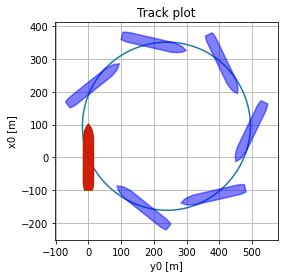

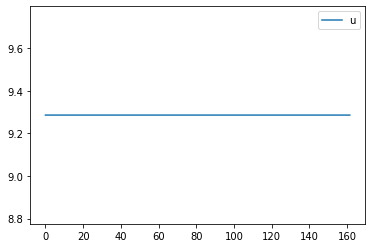

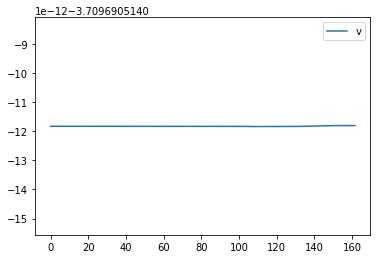

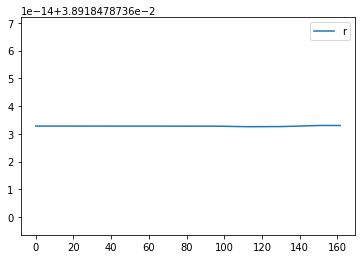

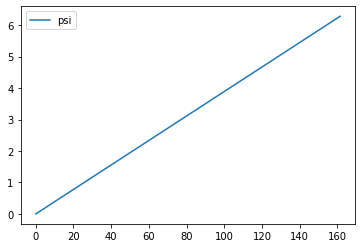

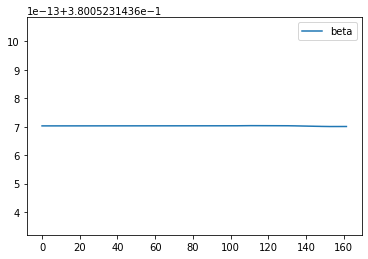

In [41]:
track_plot(df=df_result, lpp=ship_parameters['L'], beam=ship_parameters['B'])

df_result.plot(y='u')
df_result.plot(y='v')
df_result.plot(y='r')
df_result.plot(y='psi')
df_result.plot(y='beta')



## Steady turnings

In [42]:
inputs = dict(df_parameters['prime'])
inputs.update(ps.prime(ship_parameters))

U = 10
delta = np.deg2rad(35)
inputs['delta'] = delta
inputs['u'] = inputs['U'] =  ps._prime(U,'linear_velocity', U=U)

s = pd.Series(inputs)
N=10
data = np.tile(s.values,(N,1))
df_variation = pd.DataFrame(data, columns=s.index)
df_variation.head()
df_variation['delta'] = np.linspace(0.01,0.3,N)

df_variation['v'] = run(function=v_lambda, inputs=df_variation)
df_variation['r'] = run(function=r_lambda, inputs=df_variation)


<AxesSubplot:xlabel='delta'>

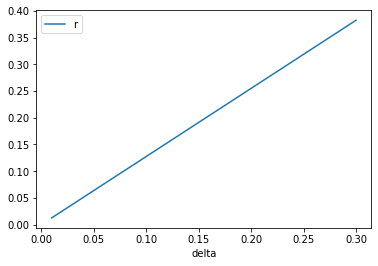

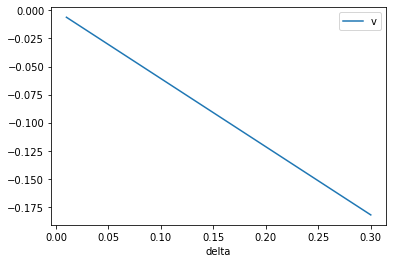

In [43]:
df_variation.plot(x='delta', y='r')
df_variation.plot(x='delta', y='v')



In [50]:
sp.solve(eq.Y_eq,v.diff())[0]

(U*m*r(t) - Y_{\delta}*delta(t) - Y_{r}*r(t) - Y_{u}*u(t) - Y_{v}*v(t))/(Y_{\dot{v}} - m)

In [51]:
sp.solve(eq.N_eq,r.diff())[0]

(N_{\delta}*delta(t) + N_{r}*r(t) + N_{u}*u(t) + N_{v}*v(t))/(I_z - N_{\dot{r}})

In [52]:
sp.solve(eq.X_eq,u.diff())[0]

(X_{\delta}*delta(t) + X_{r}*r(t) + X_{u}*u(t) + X_{v}*v(t))/(-X_{\dot{u}} + m)